In [30]:
import numpy as np
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import scipy.constants as cst
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.markers as mmarkers
from scipy.interpolate import interp1d
from specutils import Spectrum1D
import astropy.units as u
from specutils.manipulation import FluxConservingResampler
from pybaselines import whittaker
import pickle
import astropy.units as u
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.cosmology import Planck18 as cosmo
from functools import partial

noise_model_HF = pd.read_csv('TIM_SW_loading.tsv', sep='\t')
noise_model_LF = pd.read_csv('TIM_LW_loading.tsv', sep='\t')


In [31]:
#TIM params
lambda_HF = noise_model_HF["# Wavelength[um]"]*1e3 #nm
nu_HF = cst.c/(lambda_HF*1e-9)/1e9 #GHz
nHF = noise_model_HF["NEI[Jy/sr s^1/2]"]
lambda_LF = noise_model_LF["# Wavelength[um]"]*1e3 #nm
nu_LF = cst.c/(lambda_LF*1e-9)/1e9 #GHz
nLF = noise_model_LF["NEI[Jy/sr s^1/2]"]
freqs = np.concatenate((nu_LF[::-1], nu_HF[::-1]))
noise = (np.concatenate((nLF[::-1], nHF[::-1]))*u.Jy/u.sr)
lambdaw = np.concatenate((lambda_HF, lambda_LF))
noisew = (np.concatenate((nHF, nLF))*u.Jy/u.sr)

beam_FWHM_HF = 48*u.arcsec
beam_FWHM_LF = 37*u.arcsec

Omega_beam_HF = (2*np.pi*(beam_FWHM_HF * gaussian_fwhm_to_sigma)**2).to(u.sr)
#pixel_size_HF = Omega_beam_HF #((beam_FWHM_HF/2)**2).to(u.sr) #Nyquist: need to sample with 2 pixels the FWHM 
Omega_beam_LF = (2*np.pi*(beam_FWHM_LF * gaussian_fwhm_to_sigma)**2).to(u.sr)
#pixel_size_LF = Omega_beam_LF #((beam_FWHM_LF/2)**2).to(u.sr) #Nyquist: need to sample with 2 pixels the FWHM
Omega_beamw = np.concatenate((np.ones(len(nHF))*Omega_beam_HF, np.ones(len(nLF))*Omega_beam_LF))

NEFDw = noisew * Omega_beamw

5.0343237001947765 Jy


/tmp/ipykernel_670036/4274853498.py:19: RuntimeWarning: divide by zero encountered in divide
  def w_to_f(x): return cst.c/(x*1e-6)/1e9


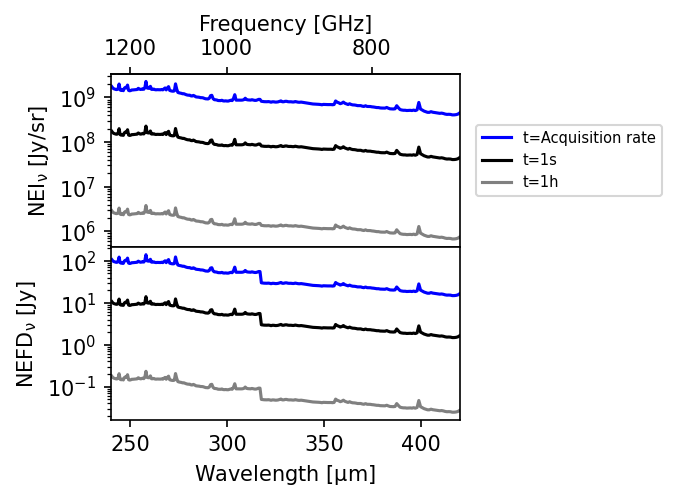

In [33]:
#compute the noise intensity out of the NEI and the survey time
t_survey = 1*3600
fig, (ax, ax2) = plt.subplots(2,figsize=(3,3), dpi=150, sharex=True )  
#ax.plot(w_source, source, 'orange', label=f'SPT0418@z={z}')
ax.loglog(lambdaw/1e3, noisew/np.sqrt(0.01),  label='t=Acquisition rate', c='b') 
ax.loglog(lambdaw/1e3, noisew, label='t=1s', c='k' )
ax.loglog(lambdaw/1e3, noisew/np.sqrt(t_survey),  label='t=1h', c='grey') 

ax2.loglog(lambdaw/1e3, NEFDw/np.sqrt(0.01),  label='Noise Intensity, t=Acquisition rate', c='b') 
ax2.loglog(lambdaw/1e3, NEFDw, label='Noise Intensity, t=1s', c='k' )
ax2.loglog(lambdaw/1e3, NEFDw/np.sqrt(t_survey),  label='Noise Intensity, t=1h', c='grey') 
ax2.set_xlabel("Wavelength [$\\rm \\mu$m]")
ax.set_ylabel("NEI$\\rm _{\\nu}$ [Jy/sr]")
ax2.set_ylabel("NEFD$\\rm _{\\nu}$ [Jy]")

ax.set_xscale("linear")
#ax.set_ylim(1e1, 1e3)
ax.set_xlim(240,420)
def w_to_f(x): return cst.c/(x*1e-6)/1e9
secax = ax.secondary_xaxis("top", functions=(w_to_f,w_to_f))
secax.set_xlabel('Frequency [GHz]')
ax.legend(fontsize=7, loc='center right', bbox_to_anchor=(1.6, 0.5))
fig.subplots_adjust(wspace=0, hspace=0)


print(np.mean(NEFDw) )